In [1]:
import os.path
import tensorflow as tf
import numpy as np
import facenet
from scipy.spatial import distance
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as mpatches
%matplotlib inline

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 16, 'axes.labelsize': 16})

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Helper functions**

In [2]:
def preprocessing(X, num_components = 50):
    num_features = X.shape[1]
    
    # Centering
    X = X - np.mean(X, axis=0)
    
    # Normalization
    X = X / X.std(axis=0)

    # PCA
    cov = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(cov)

    for ev in eig_vecs:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    pca_matrix = eig_pairs[0][1].reshape(num_features, 1)

    for i in range(1, num_components):
        pca_matrix = np.hstack((pca_matrix, eig_pairs[i][1].reshape(num_features, 1)))

    X = X.dot(pca_matrix)

    # Whitening
    X = X / np.sqrt(eig_vals[:num_components])
    
    return X

def buildFisher(emb_array, y):    
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    E = np.linalg.inv(np.cov(emb_del.T))
    M = len(emb_array)
    D = (y - (1 / (M - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    
    return w

def distance(w, sample, thr):
    return np.dot(w / np.linalg.norm(w), sample / np.linalg.norm(sample)) - thr

**Loading feature vectors and labels**

In [3]:
emb_array = np.load('./embeddings_inception_resnet_v1.npy')
train_labels = np.load('./train_labels.npy')

**Preprocessing of feature vectors (Centering -> Normalization -> PCA -> Whitening)**

In [4]:
X = preprocessing(emb_array)

**Plot of preprocessed feature vectors (2 first features)**

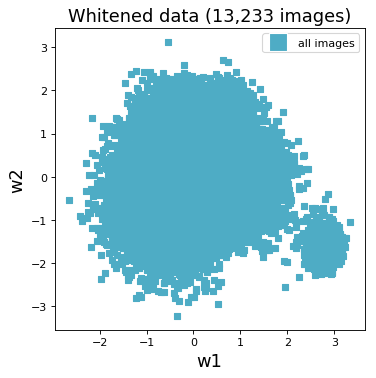

In [5]:
w1 = 0 # index of "x" feature
w2 = 1 # index of "y" feature

plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
plt.title("Whitened data (13,233 images)")
plt.scatter(X[:, w1], X[:, w2], c="#4EACC5", marker="s", s=32)
plt.xlabel("w1")
plt.ylabel("w2")
c1_patch = plt.Line2D(range(1), range(1), color="white", marker="s", markersize=16, markerfacecolor="#4EACC5", label="all images")
plt.legend(handles=[c1_patch])

**Fisher's discriminant**

Class label (class name).

In [6]:
class_label = 5

For example we take the person with class **class_label** (in this example: 5): feature vectors with indexes 5, 6, 7 and 8 corresponds to this class.

In [7]:
indexes = np.where(train_labels == class_label)[0]

In [8]:
# Removing elements of class 5 from the feature matrix
X_del = np.delete(X, indexes, axis=0)

# Build Fisher's discriminant with one element of class 5 (with index 6, for example)
w = buildFisher(X_del, X[indexes[0]])

Now we need to set a threshold and calculate distances between vector w and every vector from the dataset (feature matrix). If (distance - thr) > 0, then it is the feature vector from the same class.

In [9]:
lng = len(X)
thr = 0.7 # Threshold (experimental)
answers = []

for i in range(lng):
    l = distance(w, X[i], thr)
    answers.append(l)
    
    if l > 0 and train_labels[i] == class_label:
        []
    elif l <= 0 and train_labels[i] != class_label:
        []
    else:
        print(i, l, "(class: %d)" % train_labels[i]) # False Positive or False Negative

8 -0.11839116300269437 (class: 5)


**Calculating metrics**

Elements:              13233
False Negatives:       1
False Negatives Rate:  7.556865412227008e-05
Threshold:  0.7
Precision:  1.0
Recall:     0.75


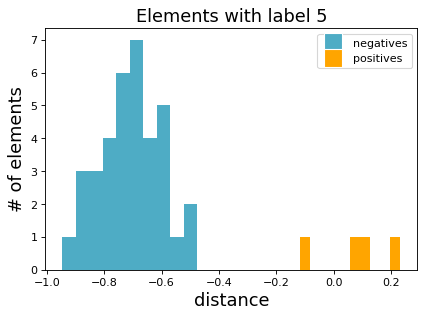

In [10]:
answers = np.asarray(answers)
true_labels = np.array(train_labels == class_label, dtype=int)
prediction = np.array(answers > 0, dtype=int)

# False Negatives (FN) and False Negatives Rate (FNR)
fn = len(prediction[prediction != true_labels])
fnr = fn / len(true_labels)

print("Elements:             ", len(prediction))
print("False Negatives:      ", fn)
print("False Negatives Rate: ", fnr)

print("Threshold: ", thr)
print("Precision: ", metrics.precision_score(true_labels, prediction))
print("Recall:    ", metrics.recall_score(true_labels, prediction))

# Histogram
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
# limit = len(answers)
limit = 40 # just for better view
plt.hist(answers[:limit][true_labels[:limit] == 0], histtype="bar", color="#4EACC5")
plt.hist(answers[:limit][true_labels[:limit] == 1], histtype="bar", color='orange')
plt.ylabel("# of elements")
plt.xlabel("distance")
plt.title("Elements with label " + str(class_label))
c1_patch = plt.Line2D(range(1), range(1), color="white", marker="s", markersize=16, markerfacecolor="#4EACC5", label="negatives")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker="s", markersize=16, markerfacecolor="orange", label="positives")
plt.legend(handles=[c1_patch, c2_patch])